In [1]:
CALCULATE = False

In [2]:
nodes = 32
randomseed = 1
D = 1.0
mep = 25
print("nodes:", nodes, "randomseed:", randomseed, "mep:", mep)

nodes: 32 randomseed: 1 mep: 25


In [3]:
import numpy as np
np.set_printoptions(suppress=True, formatter={'float': '{:.8f}'.format}, precision=8, linewidth=200)
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

np.random.seed(randomseed)
tf.random.set_seed(randomseed) 

2025-04-30 21:38:28.891669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2025-04-30 21:38:28.891725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import matplotlib.pyplot as plt
plt.style.use('default')
from taskspec.utils_3 import x_range, y_range, scale, N_sample, ker_eps_rho, n_dim, energy, ngrad, datapath, X_alg, Nnode, critical_points
from taskspec.model import DenseNet_Energy, Grad_model
from taskspec.utils import find_project_root

In [5]:
datafile = f'{datapath}/data/data/E3_d{mep}_{D}_{randomseed}.npz'
with np.load(datafile, allow_pickle=True) as data:
    xdata, ydata, rho_train = data['xdata'], data['ydata'], data['rho_train']
    assert ker_eps_rho == data['ker_eps_rho']
assert xdata.shape == (N_sample, n_dim)
assert ydata.shape == (N_sample, n_dim)
assert rho_train.shape == (N_sample, )

In [6]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

In [7]:
V_model = DenseNet_Energy(n_dim, nodes=nodes, scale=scale)
model = Grad_model(V_model)
model.build((None, n_dim))

2025-04-30 21:38:30.808200: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-30 21:38:30.818531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-04-30 21:38:30.818713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:51:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2025-04-30 21:38:30.818852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:8b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 8

In [8]:
outputfile = f'{datapath}/weights/weights_ts/E3_t{nodes}_{mep}_{randomseed}_{D}.npz'
with np.load(outputfile, allow_pickle=True) as data:
    res = data['res']
    weights1 = data['weights1']
    u_tmp1 = data['u_tmp1']
    weights_l3 = data['weights_l3']
    u_l3 = data['u_l3']
    ind_l3 = data['ind_l3']

In [9]:
# check MSE result
model.set_weights(weights1) 
def weighted_mse(y_true, y_pred, sample_weight):
    mse = tf.square(y_true - y_pred)
    weighted_mse = tf.reduce_mean(mse * sample_weight)
    return weighted_mse
with tf.GradientTape() as tape:
    predictions = model(xdata, training=True)
    loss = weighted_mse(ydata, predictions, 1)
gradients = tape.gradient(loss, model.trainable_variables)
gradientnorm = tf.linalg.global_norm(gradients).numpy()
print(f"Loading MSE weights: loss {loss}   gradientnorm {gradientnorm}")

Loading MSE weights: loss 0.0016898733463757561   gradientnorm 0.0001097393939076558


2025-04-30 21:38:31.184730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-30 21:38:31.185626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3400000000 Hz


In [10]:
with np.load(f'{datapath}/data/E3_gtstring.npz', allow_pickle=True) as data:
    xnodes_true =  data['xnodes_true']
    assert xnodes_true.shape == (Nnode, n_dim)
    fu_real = ngrad(xnodes_true)

In [11]:
model.set_weights(weights1) 
new_sample = X_alg(model, xnodes_true, N_iter=10000, dt=0.01, eps=1e-10) #u_tmp1

In [12]:
desloss = np.mean(np.linalg.norm(new_sample - xnodes_true, axis=-1))
print('desloss', desloss)

point_loss = np.sum(np.square(ngrad(new_sample) - model(new_sample)), axis=-1)
point_loss_oo = np.sqrt(np.max(point_loss))
print('point_loss_oo', point_loss_oo)

desloss 0.026477623774923183
point_loss_oo 0.11170885960287265


In [13]:
model.set_weights(weights1) 
new_sample = X_alg(model, u_tmp1, N_iter=10000, dt=0.01, eps=1e-10) 
desloss = np.mean(np.linalg.norm(new_sample - xnodes_true, axis=-1))
print('desloss', desloss)

point_loss = np.sum(np.square(ngrad(new_sample) - model(new_sample)), axis=-1)
point_loss_oo = np.sqrt(np.max(point_loss))
print('point_loss_oo', point_loss_oo)

desloss 0.026477624094024096
point_loss_oo 0.11170885768999705


In [14]:
model.set_weights(weights_l3) 
new_sample3 = X_alg(model, xnodes_true, N_iter=10000, dt=0.01, eps=1e-10) #u_tmp1

In [15]:
desloss3 = np.mean(np.linalg.norm(new_sample3 - xnodes_true, axis=-1))
print('desloss3', desloss3)

point_loss3 = np.sum(np.square(ngrad(new_sample3) - model(new_sample3)), axis=-1)
point_loss3_oo = np.sqrt(np.max(point_loss3))
print('point_loss3_oo', point_loss3_oo)

desloss3 0.0021168010143309355
point_loss3_oo 0.028312904427688346


In [16]:
model.set_weights(weights_l3) 
new_sample3 = X_alg(model, u_l3, N_iter=10000, dt=0.01, eps=1e-10) 
desloss3 = np.mean(np.linalg.norm(new_sample3 - xnodes_true, axis=-1))
print('desloss3', desloss3)

point_loss3 = np.sum(np.square(ngrad(new_sample3) - model(new_sample3)), axis=-1)
point_loss3_oo = np.sqrt(np.max(point_loss3))
print('point_loss3_oo', point_loss3_oo)

desloss3 0.002116802275799545
point_loss3_oo 0.028312904473589137


In [17]:
x = np.linspace(x_range[0], x_range[1], 101)
y = np.linspace(y_range[0], y_range[1], 101)
X, Y = np.meshgrid(x, y)
grid = np.column_stack((X.flatten(), Y.flatten(), X.flatten()*0))

e = energy(grid).reshape((101, 101))

In [18]:
ftrue = ngrad(grid).reshape((101, 101, 3))
model.set_weights(weights1) 
f1 = model(grid).numpy().reshape((101, 101, 3))
model.set_weights(weights_l3) 
f3 = model(grid).numpy().reshape((101, 101, 3))

In [19]:
e1 = np.linalg.norm(f1 - ftrue, axis=-1)
e3 = np.linalg.norm(f3 - ftrue, axis=-1)

In [20]:
meps = [0, 25, 50, 75]
rdma = 20
Ds = [0.1, 0.2, 1.0]
nodes = 32
resultss = np.zeros((len(Ds), len(meps), rdma, 4))
if CALCULATE:
    for i1, D in enumerate(Ds):
        for i2, mep in enumerate(meps):
            for i3, randomseed in enumerate(range(rdma)):
                datafile = f'{datapath}/data/data/E3_d{mep}_{D}_{randomseed}.npz'
                with np.load(datafile, allow_pickle=True) as data:
                    xdata, ydata, rho_train = data['xdata'], data['ydata'], data['rho_train']
                    assert ker_eps_rho == data['ker_eps_rho']
                assert xdata.shape == (N_sample, n_dim)
                assert ydata.shape == (N_sample, n_dim)
                assert rho_train.shape == (N_sample, )
                
                V_model = DenseNet_Energy(n_dim, nodes=nodes, scale=scale)
                model = Grad_model(V_model)
                model.build((None, n_dim))
                
                outputfile = f'{datapath}/weights/weights_ts/E3_t{nodes}_{mep}_{randomseed}_{D}.npz'
                with np.load(outputfile, allow_pickle=True) as data:
                    res = data['res']
                    weights1 = data['weights1']
                    u_tmp1 = data['u_tmp1']
                    weights_l3 = data['weights_l3']
                    u_l3 = data['u_l3']
                    ind_l3 = data['ind_l3']
                
                # check MSE resultss
                model.set_weights(weights1) 
                def weighted_mse(y_true, y_pred, sample_weight):
                    mse = tf.square(y_true - y_pred)
                    weighted_mse = tf.reduce_mean(mse * sample_weight)
                    return weighted_mse
                with tf.GradientTape() as tape:
                    predictions = model(xdata, training=True)
                    loss = weighted_mse(ydata, predictions, 1)
                gradients = tape.gradient(loss, model.trainable_variables)
                gradientnorm = tf.linalg.global_norm(gradients).numpy()
                print(f"=======================================Loading MSE weights {mep} {nodes} {randomseed}:  gradientnorm {gradientnorm}")
                assert gradientnorm < 1e-2
                
                model.set_weights(weights1) 
                new_sample = X_alg(model, u_tmp1, N_iter=10000, dt=0.01, eps=1e-10) #u_tmp1  xnodes_true
                desloss = np.mean(np.linalg.norm(new_sample - xnodes_true, axis=-1))

                point_loss = np.sum(np.square(ngrad(new_sample) - model(new_sample)), axis=-1)
                point_loss_oo = np.sqrt(np.max(point_loss))
                
                model.set_weights(weights_l3) 
                new_sample3 = X_alg(model, u_l3, N_iter=10000, dt=0.01, eps=1e-10) # u_l3    xnodes_true
                desloss3 = np.mean(np.linalg.norm(new_sample3 - xnodes_true, axis=-1))

                point_loss3 = np.sum(np.square(ngrad(new_sample3) - model(new_sample3)), axis=-1)
                point_loss3_oo = np.sqrt(np.max(point_loss3))
                
                print(D, mep, randomseed, 
                    np.array([desloss, desloss3, desloss3 / desloss]), 
                    np.array([point_loss_oo, point_loss3_oo, point_loss3_oo / point_loss_oo]), ind_l3)
                resultss[i1,i2,i3,:] = [desloss, desloss3, point_loss_oo, point_loss3_oo]
    np.savez(find_project_root() + "/examples/fig/Eg3.npz", resultss=resultss)
else:
    with np.load(find_project_root() + "/examples/fig/Eg3.npz", allow_pickle=True) as data:
        resultss = data['resultss']

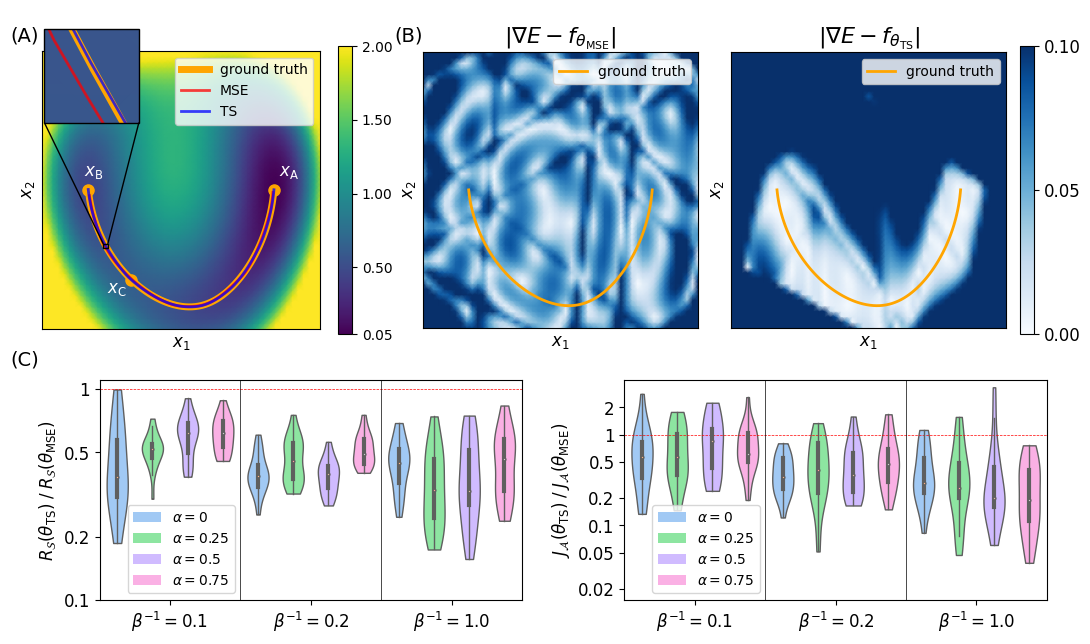

In [21]:
fig = plt.figure(figsize=(12.8, 3.6*2))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=[0.15, 0.2, 0.3, 0.3, 0.015], height_ratios=[1.2,1,2], wspace=0.15, hspace=0.3)
ax1 = fig.add_subplot(gs[:2,0:2])
ax2 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[:2,2])
ax4 = fig.add_subplot(gs[:2,3])
ax5 = fig.add_subplot(gs[:2,4])


pcm1 = ax1.pcolormesh(x,y,e, shading='gouraud', cmap='viridis', vmin=0.05, vmax=2.0)
cbar1 = fig.colorbar(pcm1, ax=ax1); pcm1.set_clim(0.05, 2.0); cbar1.set_ticks([0.05, 0.5, 1.0, 1.5, 2.0])

ax1.set_aspect('equal'); 
ax1.set_xlim([-1.5, 1.5]); ax1.set_xticks([]); ax1.set_xlabel(r'$x_1$', fontsize=12, labelpad=0)
ax1.set_ylim([-1.5, 1.5]); ax1.set_yticks([]); ax1.set_ylabel(r'$x_2$', fontsize=12, labelpad=0)

ax1.plot([1, -1, critical_points[2][0]], [0, 0, critical_points[2][1]], 'o', markersize=8, color='orange') 
points = [(1.05, 0.15, r'$x_{\mathrm{A}}$'), 
          (-1.05, 0.15, r'$x_{\mathrm{B}}$'), 
          (critical_points[2][0]-0.26, critical_points[2][1]-0.14, r'$x_{\mathrm{C}}$')]
[ax1.text(xt, yt, label, fontsize=12, color='white') for xt, yt, label in points];

ax1.plot(xnodes_true[:,0], xnodes_true[:,1], color='orange', linewidth=5, label='ground truth')
ax1.plot(new_sample[:,0], new_sample[:,1], 'r', linewidth=2, alpha=0.75, label='MSE')
ax1.plot(new_sample3[:,0], new_sample3[:,1], 'b', linewidth=2, alpha=0.75, label='TS')
ax1.legend()

h = 0.05
xa, ya = -0.84, -0.63
rect1 = patches.Rectangle((xa, ya), h, h, linewidth=1, edgecolor='k', facecolor='none', transform=ax1.transData, zorder=100)
ax1.add_patch(rect1)

ax2.patch.set_facecolor('none')
ax2.patch.set_alpha(0)  
for spine in ax2.spines.values():
    spine.set_visible(False)

rect2 = patches.Rectangle((xa, ya), h, h, linewidth=1, edgecolor='k', facecolor='none', transform=ax2.transData, zorder=100)
ax2.add_patch(rect2)

pcm2 = ax2.pcolormesh(x,y,e, shading='gouraud', cmap='viridis', vmin=0.05, vmax=2.0); pcm2.set_clim(0.05, 2.0)
pcm2.set_clip_path(rect2)
ax2.set_aspect('equal'); 

ax2.set_xlim([-0.85, -0.78]); ax2.set_xticks([]); 
ax2.set_ylim([-0.64, -0.57]); ax2.set_yticks([]); 

ax2.plot(xnodes_true[:,0], xnodes_true[:,1], color='orange', linewidth=5, label='ground truth')[0].set_clip_path(rect2)
ax2.plot(new_sample[:,0], new_sample[:,1], 'r', linewidth=2, alpha=0.75, label='MSE')[0].set_clip_path(rect2)
ax2.plot(new_sample3[:,0], new_sample3[:,1], 'b', linewidth=2, alpha=0.75, label='TS')[0].set_clip_path(rect2)

con = ConnectionPatch(
    xyA=(xa+h, ya+h), coordsA=ax1.transData,  
    xyB=(xa+h, ya), coordsB=ax2.transData,  
    arrowstyle="-", color="black", linewidth=1
)
fig.add_artist(con) 

con = ConnectionPatch(
    xyA=(xa, ya+h), coordsA=ax1.transData,  
    xyB=(xa, ya), coordsB=ax2.transData,  
    arrowstyle="-", color="black", linewidth=1
)
fig.add_artist(con) 


pcm3 = ax3.pcolormesh(x, y, e1, shading='gouraud', cmap='Blues', vmin=0, vmax=0.1)
ax3.set_aspect('equal'); 
ax3.set_xlim([-1.5, 1.5]); ax3.set_xticks([]); ax3.set_xlabel(r'$x_1$', fontsize=12, labelpad=0)
ax3.set_ylim([-1.5, 1.5]); ax3.set_yticks([]); ax3.set_ylabel(r'$x_2$', fontsize=12, labelpad=0)
ax3.plot(xnodes_true[:,0], xnodes_true[:,1], color='orange', linewidth=2, label='ground truth')
ax3.set_title(r'$\|\nabla E - f_{\theta_{\mathrm{MSE}}}\|$', fontsize=16)
ax3.legend()

pcm4 = ax4.pcolormesh(x, y, e3, shading='gouraud', cmap='Blues', vmin=0, vmax=0.1)
ax4.set_aspect('equal'); 
ax4.set_xlim([-1.5, 1.5]); ax4.set_xticks([]); ax4.set_xlabel(r'$x_1$', fontsize=12, labelpad=0)
ax4.set_ylim([-1.5, 1.5]); ax4.set_yticks([]); ax4.set_ylabel(r'$x_2$', fontsize=12, labelpad=0)
ax4.plot(xnodes_true[:,0], xnodes_true[:,1], color='orange', linewidth=2, label='ground truth')
ax4.set_title(r'$\|\nabla E - f_{\theta_{\mathrm{TS}}}\|$', fontsize=16)
ax4.legend()

cbar = fig.colorbar(pcm4, cax=ax5)
cbar.set_ticks([0.0, 0.05, 0.1])
cbar.ax.tick_params(labelsize=12)

pos_ax2 = ax2.get_position()
ax2.set_position([pos_ax2.x0 - 0.015, pos_ax2.y0 + 0.05, pos_ax2.width, pos_ax2.height])
pos_ax3 = ax3.get_position()
ax3.set_position([pos_ax3.x0 + 0.005, pos_ax3.y0, pos_ax3.width, pos_ax3.height])
pos_ax4 = ax4.get_position()
ax4.set_position([pos_ax4.x0 + 0.01, pos_ax4.y0, pos_ax4.width, pos_ax4.height])


colors = sns.color_palette("pastel", 30)

ax6 = fig.add_subplot(gs[2,2])
pos_ax6 = ax6.get_position()
ax6.set_position([0.17, pos_ax6.y0, 0.33, pos_ax6.height])

plt.axhline(y=0, color='red', linestyle='--', linewidth=0.5)  
plt.axvline(x=3.5, color='k', linestyle='-', linewidth=0.5)  
plt.axvline(x=7.5, color='k', linestyle='-', linewidth=0.5)  

df = pd.concat([
    pd.concat([
    pd.DataFrame(np.log10(resultss[j,:,:,3]/resultss[j,:,:,2]).T, 
                columns=[fr"$\alpha$=" + (str(mep/100) if mep != 0 else "0" ) + "\n" +  fr"$\beta^{-1}$={Ds[j]}"  for mep in meps])  
    ], axis=1)
    for j in [0,1,2]
    ], axis=1)
sns.violinplot(data=df, bw_adjust=.5, cut=0, linewidth=1, palette="Set3",
    scale="width",
    width=0.6)

for i, violin in enumerate(ax6.collections):
    violin.set_facecolor((*colors[i%8], 1.0))

handles = [Patch(facecolor=ax6.collections[i*2].get_facecolor()[0], 
                 label=(r'$\alpha=$' + str(mep/100) if mep != 0 else r"$\alpha=0$"))
           for i, mep in enumerate(meps)]

plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.05, 0))
plt.ylabel(r'$R_{\mathcal{S}}(\theta_{\mathrm{TS}}) \;/\; R_{\mathcal{S}}(\theta_{\mathrm{MSE}})$', fontsize=12)

yticks = [0.1, 0.2, 0.5, 1]
plt.yticks(np.log10(yticks), yticks)
plt.xticks(np.mean(np.array(plt.xticks()[0]).reshape(-1, 4), axis=1), [fr'$\beta^{{-1}}={j}$' for j in Ds])
plt.tick_params(axis='both', which='major', labelsize=12)

####
ax7 = fig.add_subplot(gs[2,3])
pos_ax7 = ax7.get_position()
ax7.set_position([0.58, pos_ax7.y0, 0.33, pos_ax7.height])
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.5)  
plt.axvline(x=3.5, color='k', linestyle='-', linewidth=0.5)  
plt.axvline(x=7.5, color='k', linestyle='-', linewidth=0.5)  
    
df = pd.concat([
    pd.concat([
        pd.DataFrame(np.log10(resultss[j,:,:,1]/resultss[j,:,:,0]).T, 
                    columns=[fr"$\alpha$=" + (str(mep/100) if mep != 0 else "0" ) + "\n" +  fr"$\beta^{-1}$={Ds[j]}"  for mep in meps])  
        ], axis=1)
    for j in [0,1,2]
    ], axis=1)

sns.violinplot(data=df, bw_adjust=.5, cut=0, linewidth=1, palette="Set3",
    scale="width",
    width=0.6)

for i, violin in enumerate(ax7.collections):
    violin.set_facecolor((*colors[i%8], 1.0))

handles = [Patch(facecolor=ax7.collections[i*2].get_facecolor()[0], 
                 label=(r'$\alpha=$' + str(mep/100) if mep != 0 else r"$\alpha=0$"))
           for i, mep in enumerate(meps)]

plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.05, 0))
plt.ylabel(r'$J_{\mathcal{A}}(\theta_{\mathrm{TS}}) \;/\; J_{\mathcal{A}}(\theta_{\mathrm{MSE}})$', fontsize=12)

yticks = [0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
plt.ylim([np.log10(0.015), np.log10(4)])
plt.yticks(np.log10(yticks), yticks)
plt.xticks(np.mean(np.array(plt.xticks()[0]).reshape(-1, 4), axis=1), [fr'$\beta^{{-1}}={j}$' for j in Ds])
plt.tick_params(axis='both', which='major', labelsize=12)

big_ax = fig.add_subplot(111, frameon=False)  
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

for label, x0, y1 in zip(['(A)', '(B)', '(C)'], 
                             [0.1, 0.4, 0.1], [0.88, 0.88, 0.43]):
    big_ax.text(x0, y1, f'{label}',
                transform=fig.transFigure,
                fontsize=14, ha='left', va='bottom')

plt.savefig(find_project_root() + "/examples/fig/Eg3.pdf", format="pdf", bbox_inches="tight")
plt.show()